# Exporting a `fastai` model to ONNX format

This notebook presents the general process of exporting a `fastai` model to ONNX format. The model is trained on the MNIST dataset.

In [1]:
# get necessary libraries
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.imports import *
from fastai.vision.all import *
from fastai.vision.utils import *
from fastai.vision.widgets import *
from fastcore.all import *

import numpy as np

import onnx
import onnxruntime as ort

import torchvision.transforms as T

In [2]:
# get MNIST dataset using `fastai` helpers
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/home/yactouat/.fastai/data/mnist_png/testing'),Path('/home/yactouat/.fastai/data/mnist_png/training')]

## Train a first iteration of a `torch` pre trained model on the MNIST dataset

In [3]:
mnist_train_digits_path = Path(path.ls()[1])

We'll use `fastai` data loaders to load the MNIST dataset. Data loaders play a crucial role as they:

- load the data into the model in batches
- apply transformations to the data
- split the data into training and validation sets
- shuffle the data

/home/yactouat/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/yactouat/.local/lib/python3.10/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


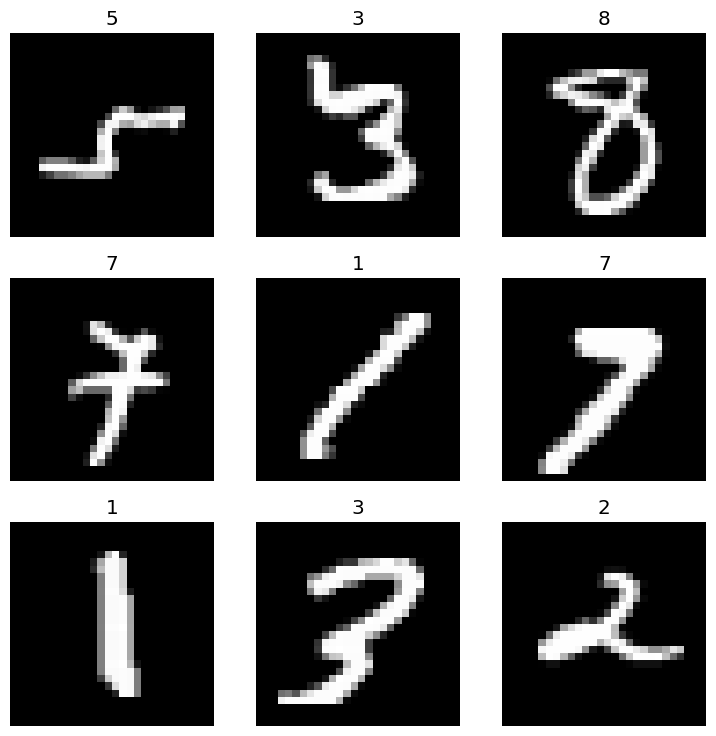

In [4]:
# creating a `fastai` data loader,
# this will create random batches of data for training and validation
mnist_data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    # this says that the parent folder name of the image will be its label
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2)
)

# the data loader will feed the images to the model in batches of 64,
# specifying the number of workers to 4 will allow to parallelize the loading of the images
mnist_data_loader = mnist_data_block.dataloaders(mnist_train_digits_path, bs=64, num_workers=4)
mnist_data_loader.show_batch(max_n=9)

# ! althuough you can't see it here, images undergo some transformations as pre processing steps (this will have its importance later on, when we will try to convert the model to ONNX format)

In [5]:
# checking if the data loader categories (labels) are correct
mnist_data_loader.vocab, mnist_train_digits_path.ls()

(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
 (#10) [Path('/home/yactouat/.fastai/data/mnist_png/training/6'),Path('/home/yactouat/.fastai/data/mnist_png/training/4'),Path('/home/yactouat/.fastai/data/mnist_png/training/9'),Path('/home/yactouat/.fastai/data/mnist_png/training/7'),Path('/home/yactouat/.fastai/data/mnist_png/training/3'),Path('/home/yactouat/.fastai/data/mnist_png/training/5'),Path('/home/yactouat/.fastai/data/mnist_png/training/8'),Path('/home/yactouat/.fastai/data/mnist_png/training/2'),Path('/home/yactouat/.fastai/data/mnist_png/training/1'),Path('/home/yactouat/.fastai/data/mnist_png/training/0')])

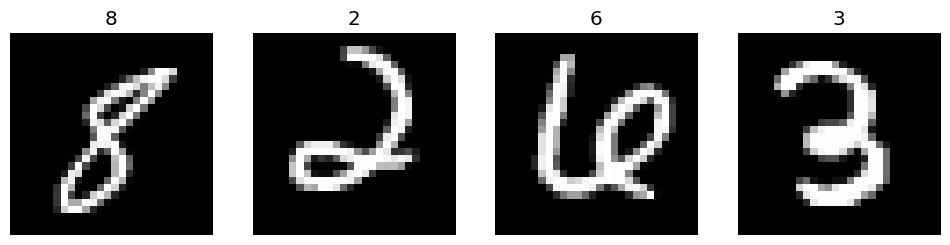

In [6]:
# let's see what we have in our validation set
mnist_data_loader.valid.show_batch(max_n=4, nrows=1)

In [7]:
# training the model, go get a coffee as this will take a while
mnist_learner = vision_learner(mnist_data_loader, resnet18, metrics=accuracy)
mnist_learner.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.750357,0.535798,0.831667,00:29


epoch,train_loss,valid_loss,accuracy,time
0,0.130882,0.073821,0.974917,01:00


In [8]:
# these were the transformations that were applied to the images at itemlevel when the model was trained
print(mnist_data_loader.after_item)

# the ouput basically says that each `PIL` image from the dataset has been turned into a tensor,
# in this case it's an int tensor

Pipeline: ToTensor


In [9]:
# these were the transformations that were applied to the images at batch level when the model was trained
print(mnist_data_loader.after_batch)

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}


As you can see from the previous output, several things are happening here:

- 1st transformation: the int tensor is converted to a float tensor, models work better with floating point numbers as they can represent a wider range of values
- 1st transformation: values in the float tensor are divided by `255.0` to get values between 0 and 1 (normalization), this speeds up the training process
- 2nd transformation: the images are normalized again using the _mean_ and _standard deviation_ of the MNIST dataset: `'axes': (0, 2, 3)` means we are calculating the mean and standard deviation for each channel across all images and pixels in those channels; this is why you're not seeing the channel axis here; standard deviation is a measure of how dispersed the set of values is 

In [11]:
# export the learner
mnist_learner.export('exported/mnist_model.pkl')

## Prepare the model for export to ONNX format

In [12]:
# reloading the learner to avoid running the whole notebook again
learner = load_learner('exported/mnist_model.pkl')

In [13]:
# check that our exported model can read image matrices as inputs
test_img = PILImage.create('example_mnist_6_digit.png')

preds, _, probs = learner.predict(test_img)

preds, probs

/home/yactouat/.local/lib/python3.10/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


('6',
 tensor([8.1033e-05, 2.4610e-06, 7.0510e-06, 2.2816e-06, 3.8952e-06, 2.4798e-05, 9.9987e-01, 2.0386e-07, 1.1940e-05, 4.8306e-07]))

In [14]:
# checking what the expected input looks like
test_img.shape, test_img.getbands(), tensor(test_img).shape

((28, 28), ('R', 'G', 'B'), torch.Size([28, 28, 3]))

In [15]:
# we need to create a fake input to be able to export the model,
# it is, in our case in the form  => (batch_size, channels, height, width);
dummy_input = torch.randn(1, 3, 28, 28)

dummy_input.shape

torch.Size([1, 3, 28, 28])

In [16]:
# reloading the model's data loader (necessary for the export to work)
learner.dls = mnist_data_loader

In [17]:
# getting the underlying pytorch model
pytorch_model = learner.model

## Export the model in ONNX format

PyTorch models are exportable in ONNX format, so the first thing to do is to get the underlying PyTorch model from the `fastai` learner.

In [18]:
# setting the model to evaluation mode,
# this means that some normalization and dropout layers will be disabled to ensure a more deterministic behavior
pytorch_model.eval()

# specify input and output names of the exported model
input_names = ["input_image"]
output_names = ["digit_prediction"]

# ! choose either MNIST or business model
torch.onnx.export(

    # moving the model to CPU,
    # this ensures that the consuming machine will run inference on the CPU (better portability)
    pytorch_model.cpu(),

    dummy_input.cpu(), 
    
    'exported/mnist_model.onnx',

    # compiler optimizations
    do_constant_folding=True,

    # store the trained parameter weights inside the model file         
    export_params=True,

    input_names=input_names,
    output_names=output_names,

    # indicate which axes of the input and output tensors should be treated as dynamic;
    # here, specifying `{0: "batch_size"}` for I/O indicates that we will be able to run mass inference with the exported model 
    dynamic_axes={
        'input_image': {0: 'batch_size'},
        'digit_prediction': {0: "batch_size"}
    }
)

## Validating that our ONNX exports works as expected using Python

In [19]:
model = onnx.load("exported/mnist_model.onnx")
try:
    onnx.checker.check_model(model)
    print("The model is valid!")
except onnx.checker.ValidationError as e:
    print(f"The model is invalid: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

The model is valid!


In [20]:
session = ort.InferenceSession("exported/mnist_model.onnx")

to_tensor = T.ToTensor()
input_data = (to_tensor(test_img)).unsqueeze(0).numpy()
input_data.shape

(1, 3, 28, 28)

In [21]:
inputs = {session.get_inputs()[0].name: input_data}
outputs = session.run(None, inputs)
digit_prediction = outputs[0]
predicted_digit = np.argmax(digit_prediction, axis=1)
print("Predicted Digit:", predicted_digit)

Predicted Digit: [1]


Now all we have to do is to test how to read this on C# side. 

It will be necessary to compare the performance of the original model with the exported model to see if there is any discrepancy between the two.